# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru
- **Поддержка CUDA**: А.Е.Григорьева admin@linkennt.ru
- **Ревизия**: 8

- **Другие ревизии**: [ссылка](https://disk.yandex.ru/d/aZozDpBlzh_z1A)
<!-- please do not append text into this block -->

- [x] Добавить 2x больше эпох на датасетах, где был плохой перфоманс (1, 2, 5, 7, 8)
- [x] Примешивать к целевой переменной на этапе обучения шум с амплитудой ~0,03 дисперсии
- [x] Обучить модели без шума для сравнения
- [ ] Отображать правильную шкалу шума
- [ ] Подмешивать стабильно распределённый шум, варьируя $\alpha$ от 1 до 2

NOTE: levy distribution нам не подходит, у него фиксированная $\alpha = 0.5$


## Setup

In [83]:
from cgtnnlib.constants import LEARNING_RATE, RANDOM_STATE
import cgtnnlib.training as tr
import cgtnnlib.datasets as ds
from cgtnnlib.ExperimentParameters import ExperimentParameters
from cgtnnlib.NoiseGenerator import target_dispersion_scaled_noise, stable_noise, no_noise_generator


iterations = 10
epochs = 10
modelset = ds.datasets[2]
pp = [0.0, 0.5, 0.9]


datasets = [
    ds.datasets['StudentPerformanceFactors'],
    ds.datasets['wine_quality'],
]

ng_makers = [
    lambda dataset: no_noise_generator,
    lambda dataset: target_dispersion_scaled_noise(
        dataset=dataset,
        factor=0.03,
        random_seed=RANDOM_STATE + 1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.25,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.5,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.75,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=2.0,
        beta=1,
    ),
]

double_epochs_datasets = [
    ds.datasets[0], # 1
    ds.datasets[1], # 2
    ds.datasets[4], # 5
    ds.datasets[6], # 7
    ds.datasets[7], # 8
]


## Генерация стабильного шума

Используется алгоритм Chambers-Mallows-Stuck (CMS) [1]. Реализация в файле *cgtnnlib/NoiseGenerator.py*.

In [86]:

from cgtnnlib.NoiseGenerator import stable_noise

ng = stable_noise(
    dataset=datasets[0],
    factor=0.03,
    alpha=1,
    beta=0.0
)

print(ng.name)
[ng.next_sample() for _ in range(10)]

Stable3A1B0.0F0.03


[-0.8675332846433698,
 0.7457358632555929,
 0.28326285836139864,
 -0.22162692917223767,
 0.32439359672194656,
 -0.3143748583263694,
 0.48482274767587524,
 -1.0282029737639276,
 -2.647144329866885,
 0.3294719974967048]

## Training

- both take ~5m 06s to train 10 iterations
- both on both noises: about ~10m

<hr>

- `ds.datasets['StudentPerformanceFactors']` takes ~2m 30s to train 10 iterations
- `ds.datasets['wine_quality']` takes ~2m 36s to train 10 iterations

### Target noise

In [84]:
for i, modelset in enumerate(datasets):
    for ng_maker in ng_makers:
        for p in pp:
            noise_generator = ng_maker(modelset)
            for iteration in range(iterations):
                experiment_params = ExperimentParameters(iteration, p=p)

                tr.create_and_train_model(
                    modelset,
                    epochs,
                    learning_rate=LEARNING_RATE,
                    dry_run=False,
                    p=p,
                    iteration=iteration,
                    noise_generator=noise_generator
                )

N=9 #6 gStable6A2.0B1F0.03 p=0.9 E9/10 S434 Loss=nan@AugmentedReLUNetwork
create_and_train_model(): saved model to pth//cgtnn-6Y-AugmentedReLUNetwork-gStable6A2.0B1F0.03-P0.9_N9.pth
Report saved to pth/cgtnn-6Y-AugmentedReLUNetwork-gStable6A2.0B1F0.03-P0.9_N9.json.


### 2x epochs

In [3]:
for i, modelset in enumerate(double_epochs_datasets):
    for p in pp:
        for iteration in range(iterations):
            experiment_params = ExperimentParameters(iteration, p=p)

            tr.create_and_train_model(
                modelset,
                epochs * 2,
                learning_rate=LEARNING_RATE,
                dry_run=False,
                p=p,
                iteration=iteration,
                noise_generator=no_noise_generator
            )

N=9 #8 gNoNoise p=0.9 E19/20 S81 Loss=4.2432@AugmentedReLUNetwork
create_and_train_model(): saved model to pth//cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.9_N9.pth
Report saved to pth/cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.9_N9.json.


## Evaluation

both take 42s

120 take 4m 10.9s

(need evaluation skip check??)

In [85]:
from cgtnnlib.EvaluationParameters import EvaluationParameters
from cgtnnlib.Report import Report
from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork
import cgtnnlib.evaluate as ev
import cgtnnlib.datasets as ds
import cgtnnlib.path as ph
from cgtnnlib.ExperimentParameters import ExperimentParameters


for i, modelset in enumerate(datasets):
    for ng_maker in ng_makers:
        for p in pp:
            noise_generator = ng_maker(modelset)

            for iteration in range(iterations):
                experiment_params = ExperimentParameters(iteration, p=p)
                
                eval_params = EvaluationParameters(
                    dataset=modelset,
                    model_path=ph.model_path(
                        dataset_number=modelset.number,
                        model_type=AugmentedReLUNetwork,
                        p=p,
                        iteration=iteration,
                        noise_generator=noise_generator,
                    ),
                    experiment_parameters=experiment_params,
                    report_key=ph.eval_report_key(
                        model_name=AugmentedReLUNetwork.__name__,
                        dataset_number=modelset.number,
                        p=p,
                        iteration=iteration,
                    )
                )
                
                report_name = ph.model_name(
                    dataset_number=modelset.number,
                    model_type=AugmentedReLUNetwork,
                    p=p,
                    iteration=iteration,
                    noise_generator=noise_generator
                )

                report = Report(
                    dir='pth/',
                    filename=report_name + '.json',
                    must_exist=True,
                )
                
                ev.eval_inner(
                    eval_params=eval_params,
                    constructor=AugmentedReLUNetwork,
                    report=report
                )
                
                report.save()

Evaluating model at pth//cgtnn-3Y-AugmentedReLUNetwork-gStable3A1.25B1F0.03-P0.0_N0.pth...


ValueError: Input contains NaN.

## Analysis

         0.25       0.75       mean
0   15.291445  17.160938  16.537011
1   15.329885  17.209813  16.559540
2   15.312329  17.170544  16.574338
3   15.350167  17.298760  16.636616
4   15.427682  17.372920  16.738289
5   15.697343  17.678886  16.895487
6   15.877092  17.814281  17.076671
7   16.115637  17.723045  17.176022
8   16.305419  17.999850  17.514541
9   16.598117  18.191100  17.853538
10  16.760220  18.451449  17.997093
11  16.740972  18.890928  18.199505
12  17.214753  19.227859  18.418247
13  17.669774  19.179573  18.896795
14  18.385823  19.668053  19.393757
15  18.202283  20.425632  19.736619
16  18.393041  20.396713  19.916180
17  19.740103  20.189195  20.265571
18  19.840150  21.044224  20.999030
19  19.697286  22.133748  21.443558
20  20.781103  22.785418  22.122725
21  21.034531  23.065753  22.788747
22  22.021354  23.393993  23.311683
23  22.197489  23.540345  23.591349
24  23.226900  24.641185  24.437822
25  23.019112  25.112085  24.897977
26  24.102743  26.939347  26

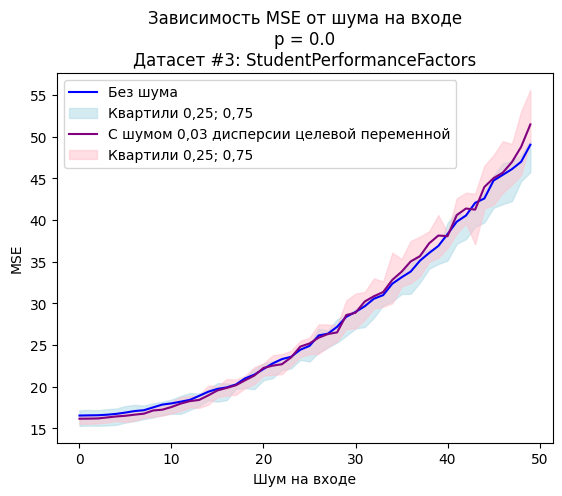

         0.25       0.75       mean
0   17.058297  17.954195  17.997389
1   17.071027  17.988503  17.992850
2   17.113317  17.974159  18.040593
3   17.221451  18.204622  18.139329
4   17.328053  18.103714  18.180730
5   17.400560  18.299936  18.330167
6   17.507356  18.443420  18.432457
7   17.916361  18.921294  18.785870
8   18.138020  19.027007  18.955403
9   18.442790  19.037235  19.067020
10  18.417276  19.711099  19.314767
11  18.875986  19.478348  19.659576
12  19.005795  20.205963  19.998505
13  19.153213  20.179718  20.061359
14  19.812775  20.916512  20.777735
15  20.335149  21.148111  21.063878
16  20.699125  21.335773  21.367630
17  20.736324  22.154947  21.844043
18  22.028933  22.966122  22.727170
19  21.772839  23.548223  22.705434
20  22.887545  24.276104  23.686727
21  23.138595  24.765053  24.022070
22  23.993168  24.624086  24.633525
23  24.009262  25.490743  24.908307
24  24.958091  25.689823  25.625737
25  25.653766  27.190707  26.544348
26  26.444918  27.503760  27

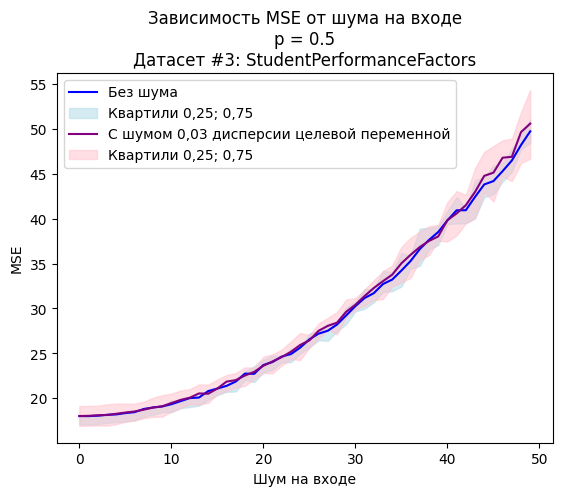

         0.25       0.75       mean
0   17.700145  18.448997  18.316080
1   17.701397  18.475266  18.325983
2   17.728993  18.478303  18.331719
3   17.650490  18.511273  18.349744
4   17.890259  18.604985  18.481826
5   17.780909  18.699833  18.505623
6   17.969601  18.777619  18.594954
7   18.128292  18.833707  18.741496
8   18.115726  18.893377  18.751097
9   18.369227  19.055570  18.918967
10  18.290082  19.170052  19.035892
11  18.659597  19.445038  19.362071
12  18.769584  19.750119  19.475111
13  19.332666  19.988074  19.866239
14  19.376155  20.014514  19.911575
15  19.185933  20.095550  19.949108
16  19.855109  20.194479  20.327334
17  20.044991  20.596094  20.680358
18  20.449476  21.341545  21.089852
19  20.862654  21.693204  21.472979
20  20.934685  21.988948  21.517630
21  21.018497  22.231346  21.776121
22  21.835587  22.691019  22.401718
23  21.909163  22.862170  22.629581
24  22.565811  23.688749  23.071213
25  22.305435  23.219450  22.990290
26  23.371185  24.359810  23

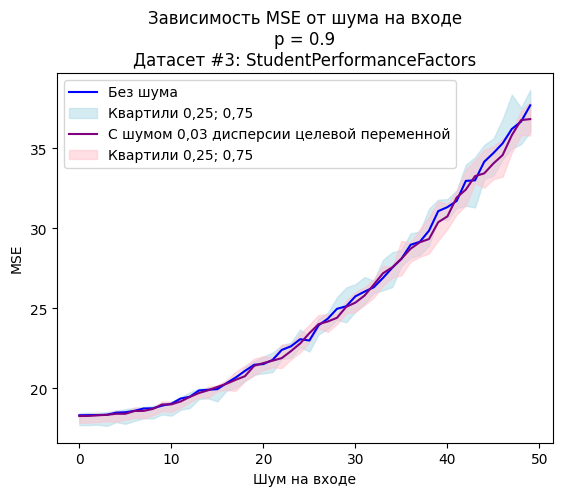

        0.25      0.75      mean
0   0.805174  1.288117  1.135087
1   0.805951  1.291098  1.137354
2   0.809786  1.293516  1.140585
3   0.811778  1.289901  1.143752
4   0.832341  1.293775  1.151302
5   0.826537  1.309905  1.159697
6   0.854393  1.316683  1.173230
7   0.845588  1.306804  1.169057
8   0.871287  1.345111  1.196183
9   0.879136  1.364860  1.204400
10  0.900507  1.367226  1.231136
11  0.919183  1.413914  1.248400
12  0.919878  1.428265  1.266612
13  0.959823  1.445792  1.297443
14  0.978802  1.448847  1.320033
15  1.013718  1.497953  1.350787
16  1.060294  1.524015  1.381639
17  1.084645  1.522814  1.397795
18  1.112649  1.601572  1.431830
19  1.157385  1.628966  1.504953
20  1.199282  1.683163  1.523010
21  1.242463  1.714381  1.556825
22  1.262874  1.720496  1.601870
23  1.334256  1.846074  1.636456
24  1.364127  1.779274  1.681895
25  1.351356  1.895840  1.727537
26  1.457366  1.893257  1.755767
27  1.464613  1.959974  1.823873
28  1.540390  2.035934  1.881533
29  1.6597

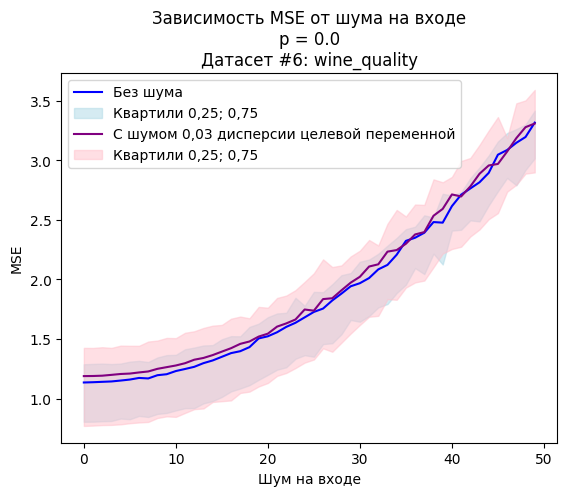

        0.25      0.75      mean
0   0.768181  1.009349  0.935403
1   0.769013  1.009950  0.936266
2   0.776117  1.008913  0.938914
3   0.766645  1.009064  0.939101
4   0.776361  1.025277  0.946560
5   0.781601  1.025003  0.951925
6   0.793321  1.023164  0.957534
7   0.796215  1.038306  0.969393
8   0.796042  1.053112  0.977752
9   0.802841  1.068860  0.991624
10  0.831780  1.061022  0.998775
11  0.840757  1.088670  1.011312
12  0.839581  1.090441  1.015254
13  0.878913  1.110198  1.039216
14  0.891563  1.130293  1.054005
15  0.897402  1.145448  1.070222
16  0.935487  1.172064  1.099250
17  0.942052  1.140213  1.105484
18  0.978198  1.181035  1.131368
19  0.979563  1.212908  1.143598
20  1.010148  1.211341  1.178235
21  1.044491  1.266441  1.212007
22  1.046778  1.289728  1.227812
23  1.085424  1.297671  1.263570
24  1.145573  1.326456  1.304466
25  1.147683  1.347066  1.312134
26  1.192575  1.348556  1.324532
27  1.227020  1.428598  1.384820
28  1.294540  1.380275  1.415104
29  1.2675

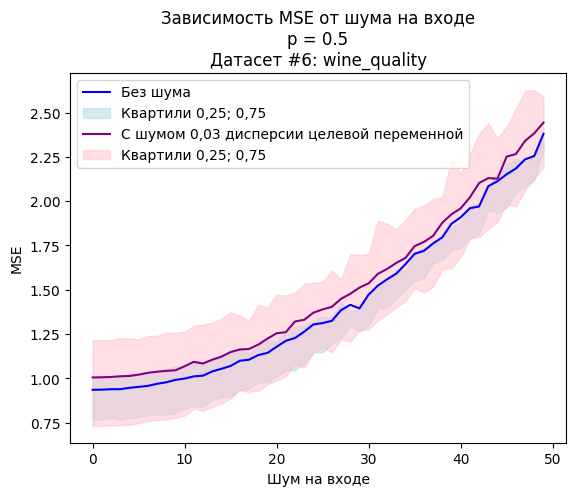

        0.25      0.75      mean
0   0.761602  1.122878  0.953495
1   0.763473  1.123726  0.954394
2   0.763271  1.121834  0.954890
3   0.762576  1.127764  0.955498
4   0.766839  1.122708  0.956454
5   0.768209  1.135762  0.959345
6   0.768911  1.133777  0.961954
7   0.776489  1.146044  0.968884
8   0.778891  1.141939  0.973667
9   0.794823  1.155997  0.977949
10  0.797373  1.158543  0.986363
11  0.794399  1.147008  0.987892
12  0.810535  1.178108  1.001395
13  0.815083  1.166549  1.001809
14  0.822018  1.213221  1.019258
15  0.832046  1.176582  1.023062
16  0.846216  1.230006  1.038430
17  0.855216  1.209790  1.041891
18  0.874159  1.223977  1.059262
19  0.868715  1.223024  1.054547
20  0.890942  1.246209  1.084068
21  0.899099  1.245754  1.088939
22  0.902269  1.298906  1.103968
23  0.957647  1.303537  1.130328
24  0.937596  1.306854  1.126226
25  0.985965  1.278342  1.141798
26  1.010343  1.339055  1.170171
27  0.992564  1.368859  1.187701
28  0.981181  1.384813  1.205564
29  1.0249

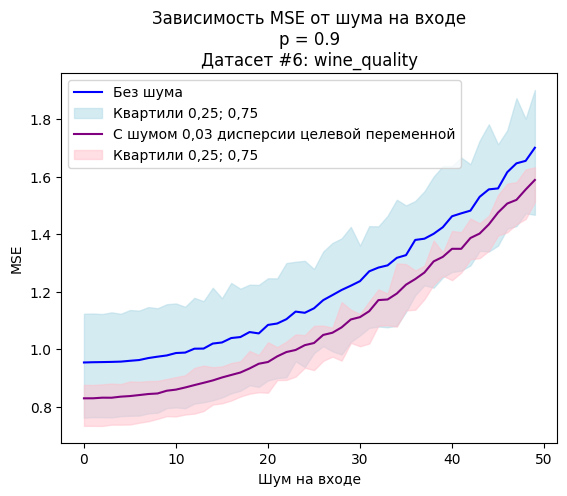

In [12]:
import json

import pandas as pd

import matplotlib.pyplot as plt

from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt



def read_json(path: str) -> dict:
    with open(path) as file:
        return json.load(file)

def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame({
        0.25: df.quantile(0.25, axis=1),
        0.75: df.quantile(0.75, axis=1),
        'mean': df.mean(axis=1),
    })

    return summary_df

for dataset in datasets:
    for p in pp:
        prefixes = [
            f'cgtnn-{dataset.number}Y-AugmentedReLUNetwork-g{ng_maker(dataset).name}-P{p}_'
            for ng_maker in ng_makers
        ]
        
        files = [
            [
                pd.DataFrame(
                    read_json(
                        'pth/' + prefix + 'N' + str(n) + '.json'
                    )['eval']
                )
                for n in range(iterations)
            ]
            for prefix in prefixes
        ]

        no_noise = summarize_series_list([file['mse'] for file in files[0]])
        some_noise = summarize_series_list([file['mse'] for file in files[1]])

        print(no_noise)
        
        plot_deviant_curves_on_ax_or_plt(
            ax_or_plt=plt,
            models=[{
                'curve': no_noise,
                'color': 'blue',
                'label': 'Без шума',
                'quantiles_color': 'lightblue',
                'quantiles_label': 'Квартили 0,25; 0,75',
            }, {
                'curve': some_noise,
                'color': 'purple',
                'label': 'С шумом 0,03 дисперсии целевой переменной',
                'quantiles_color': 'pink',
                'quantiles_label': 'Квартили 0,25; 0,75', 
            }],
            title='\n'.join([
                # 'Кривая потерь, обучение с +0.03 шумом на входе',
                'Зависимость MSE от шума на входе',
                f'p = {p}',
                f'Датасет #{dataset.number}: {dataset.name}'
            ]),
            xlabel='Шум на входе',
            ylabel='MSE',
            quantiles_alpha=0.5,
        )
        plt.show()

In [4]:

files

['cgtnn-6-AugmentedReLUNetwork-TDS6-0.0',
 'cgtnn-6-AugmentedReLUNetwork-TDS6-0.5',
 'cgtnn-6-AugmentedReLUNetwork-TDS6-0.9']

In [ ]:
('grouping_key')
for modelset, rows in grouped:
    print(modelset)

In [ ]:
ed:
    print('group', modelset)
    print('rows', type(rows))

    losses: list[pd.DataFrame] = []
    evals: list[pd.DataFrame] = []

    reports = [
        Report(dir='pth/', filename=filename)
        for filename in rows['filename']
    ]
    
    # curve = summarize_series_list(
    #     list(map(lambda x: pd.Series(x.get('loss')), reports))
    # )

    curve = summarize_series_list(
        list(map(lambda x: pd.DataFrame(x.get('eval'))['mse'], reports))
    )
    
    dataset_name = reports[0].get('dataset').get('name')
    dataset_number = reports[0].get('dataset').get('number')

    plot_deviant_curves_on_ax_or_plt(
        ax_or_plt=plt,
        models=[{
            'curve': curve,
            'color': 'blue',
            'label': 'Среднее',
            'quantiles_color': 'lightgray',
            'quantiles_label': 'Квартили 0,25; 0,75',
        }],
        title='\n'.join([
            # 'Кривая потерь, обучение с +0.03 шумом на входе',
            'Зависимость MSE от шума на входе',
            'Ключ: ' + modelset,
            f'Датасет #{dataset_number}: {dataset_name}'
        ]),
        xlabel='Шум на входе',
        ylabel='MSE',
        quantiles_alpha=0.5,
    )
    
    plt.grid()
    plt.show()


## References

1. Chambers, J. M., Mallows, C. L., & Stuck, B. W. (1976). A method for simulating stable random variables. *Journal of the American Statistical Association*, *71*(354), 340-344.